# Analysis of the San Francisco data

Data file used
* sanfrancisco_incidents_summer_2014.csv


# Exploring the Data

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib

import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

In [2]:
incidents = pd.read_csv('sanfrancisco_incidents_summer_2014.csv')
incidents.columns = ['Id','Category','Description','DayOfWeek','Date','Time','District','Resolution','Address','Longitude','Latitude','Location','PdId']
pd.DataFrame(incidents.columns)

,0
0,Id
1,Category
2,Description
3,DayOfWeek
4,Date
5,Time
6,District
7,Resolution
8,Address
9,Longitude


In [3]:
sfo_incident_category = pd.DataFrame(pd.unique(incidents.Category.ravel()))
sfo_incident_category

,0
0,ARSON
1,NON-CRIMINAL
2,LARCENY/THEFT
3,DRUG/NARCOTIC
4,DRIVING UNDER THE INFLUENCE
5,OTHER OFFENSES
6,TRESPASS
7,VEHICLE THEFT
8,ASSAULT
9,FRAUD


In [4]:
incidents.head(5)

,Id,Category,Description,DayOfWeek,Date,Time,District,Resolution,Address,Longitude,Latitude,Location,PdId
0,140734311,ARSON,ARSON OF A VEHICLE,Sunday,08/31/2014,23:50,BAYVIEW,NONE,LOOMIS ST / INDUSTRIAL ST,-122.405647,37.738322,"(37.7383221869053, -122.405646994567)",14073431126031
1,140736317,NON-CRIMINAL,LOST PROPERTY,Sunday,08/31/2014,23:45,MISSION,NONE,400 Block of CASTRO ST,-122.435012,37.761768,"(37.7617677182954, -122.435012093789)",14073631771000
2,146177923,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,08/31/2014,23:30,SOUTHERN,NONE,1000 Block of MISSION ST,-122.409795,37.780036,"(37.7800356268394, -122.409795194505)",14617792306244
3,146177531,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,08/31/2014,23:30,RICHMOND,NONE,FULTON ST / 26TH AV,-122.485263,37.772518,"(37.7725176473142, -122.485262988324)",14617753106244
4,140734220,NON-CRIMINAL,FOUND PROPERTY,Sunday,08/31/2014,23:23,RICHMOND,NONE,800 Block of LA PLAYA ST,-122.509895,37.772313,"(37.7723131976814, -122.509895418239)",14073422072000


### Initial observations

1. San Fransisco data set has the information on the resolution for the incident which could potentially be used to analyze how many of the reported incidents have been resolved. In other words the efficiency of the SFO PD in resolving the incidents. However there is no resolution date.
3. Data sets include longitude and latitide information, which if plotted on a map may provide patterns in the clustering of the incident locations. This may help map out higher crime rate areas v/s lower crime rate areas
4. Day of the week column is present in the SFO data set but is absent from the seattle data set. 

## Validations

1. Consistency check. We'll check the dates and identify rows where the dates are inconsistent. There is a year column in the seattle data which can potentially help in this effort.
2. Completeness check: There may be missing information in some rows which would need to be either discarded or corrected if possible. 

### Completeness check for SFO

In [5]:
missing_count = {}
for col_name in incidents.columns:
    count_of_null = len(incidents[incidents[col_name].isnull()])
    if count_of_null > 0:
        missing_count[col_name] = count_of_null
if len(missing_count) == 0:
    print "All columns have data for all rows"
else:
    print "List of columns and the count of rows which have missing data"
    pd.DataFrame(missing_count)

All columns have data for all rows


### Consistency Check for SFO

In [7]:
# the date and time of incident are in two separate columns
# combining them into a date_time column
incidents['DateTime'] = pd.to_datetime(incidents['Date'] + ' ' + incidents['Time'])
date_idx = pd.DatetimeIndex(incidents['DateTime'])
#incidents['Date'] = date_idx.date.astype('datetime64')
incidents['Hour'] = date_idx.hour
incidents['Year'] = date_idx.year
incidents['Month'] = date_idx.month
incidents['Weekday'] = date_idx.weekday

In [8]:
pd.DataFrame({'count' : incidents.groupby( ['Year','Month'] ).size()}).reset_index()

,Year,Month,count
0,2014,6,9114
1,2014,7,9671
2,2014,8,10208


There is only one year and data spans for the three months of Jun-Aug. Looks consistent although there is no way to confirm.

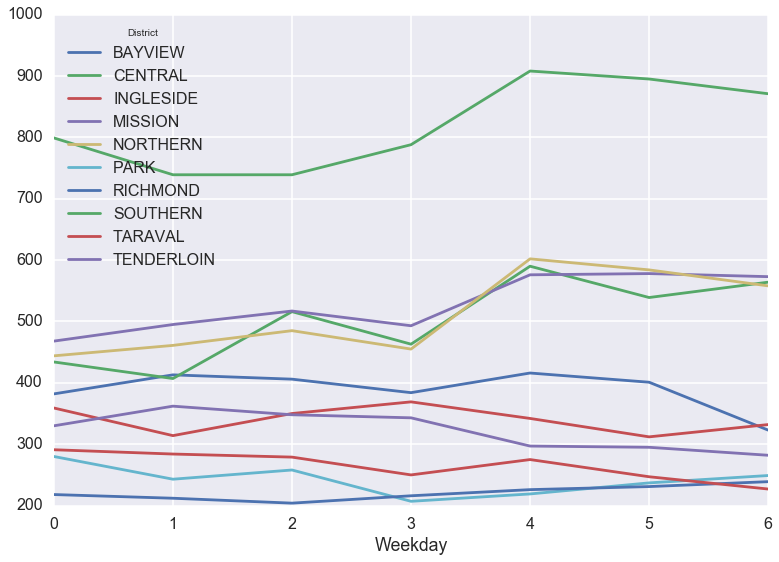

In [9]:
by_year = incidents.pivot_table('Id', aggfunc='count',
                            index='Weekday',
                            columns='District')
ax = by_year.plot(kind="line",sort_columns=True)

## Incident Categorization based on this site

http://www.legalmatch.com/law-library/article/what-are-the-different-types-of-crimes.html

I took the 4 prominent categories and remapped them to the best of my knowledge. 

* __Personal Crimes__ – “Offenses against the Person”: These are crimes that result in physical or mental harm to another person. 
* __Property Crimes__ – “Offenses against Property”: These are crimes that do not necessarily involve harm to another person. Instead, they involve an interference with another person’s right to use or enjoy their property.
* __Inchoate Crimes__ – “Inchoate” translates into “incomplete”, meaning crimes that were begun, but not completed. This requires that a person take a substantial step to complete a crime, as opposed to just “intend” to commit a crime. 
* __Statutory Crimes__ – A violation of a specific state or federal statute and can involve either property offenses or personal offense.
* __Other Offences__ – Anything that could not be mapped to the above 4 categories

See more at: http://www.legalmatch.com/law-library/article/what-are-the-different-types-of-crimes.html#sthash.xHKGRbs4.dpuf



In [10]:
category_groups = {
'[INC - CASE DC USE ONLY]': 'OTHER OFFENSES',
'ANIMAL COMPLAINT': 'OTHER OFFENSES',
'ARSON': 'PROPERTY',
'ASSAULT': 'PERSONAL',
'BIAS INCIDENT': 'INCHOATE',
'BIKE THEFT': 'PROPERTY',
'BRIBERY': 'PROPERTY',
'BURGLARY': 'PROPERTY',
'BURGLARY-SECURE PARKING-RES': 'PROPERTY',
'CAR PROWL': 'INCHOATE',
'COUNTERFEIT': 'PROPERTY',
'DISORDERLY CONDUCT': 'INCHOATE',
'DISPUTE': 'INCHOATE',
'DISTURBANCE': 'INCHOATE',
'DRIVING UNDER THE INFLUENCE': 'STATUTORY',
'DRUG/NARCOTIC': 'STATUTORY',
'DRUNKENNESS': 'STATUTORY',
'DUI': 'STATUTORY',
'ELUDING': 'INCHOATE',
'EMBEZZLE': 'PROPERTY',
'EMBEZZLEMENT': 'PROPERTY',
'ESCAPE': 'STATUTORY',
'EXTORTION': 'INCHOATE',
'FALSE REPORT': 'INCHOATE',
'FAMILY OFFENSES': 'INCHOATE',
'FIREWORK': 'PROPERTY',
'FORGERY': 'PROPERTY',
'FORGERY/COUNTERFEITING': 'PROPERTY',
'FRAUD': 'PROPERTY',
'GAMBLING': 'PROPERTY',
'HOMICIDE': 'PERSONAL',
'ILLEGAL DUMPING': 'STATUTORY',
'INJURY': 'PERSONAL',
'KIDNAPPING': 'PERSONAL',
'LARCENY/THEFT': 'PROPERTY',
'LIQUOR LAWS': 'STATUTORY',
'LIQUOR VIOLATION': 'STATUTORY',
'LOITERING': 'INCHOATE',
'LOST PROPERTY': 'PROPERTY',
'MAIL THEFT': 'PROPERTY',
'MISSING PERSON': 'PERSONAL',
'NARCOTICS': 'STATUTORY',
'NON-CRIMINAL': 'NON-CRIMINAL',
'OBSTRUCT': 'PROPERTY',
'OTHER OFFENSES': 'OTHER OFFENSES',
'OTHER PROPERTY': 'PROPERTY',
'PICKPOCKET': 'PROPERTY',
'PORNOGRAPHY': 'INCHOATE',
'PORNOGRAPHY/OBSCENE MAT': 'INCHOATE',
'PROPERTY DAMAGE': 'PROPERTY',
'PROSTITUTION': 'INCHOATE',
'PUBLIC NUISANCE': 'INCHOATE',
'PURSE SNATCH': 'PROPERTY',
'RECKLESS BURNING': 'PROPERTY',
'RECOVERED PROPERTY': 'PROPERTY',
'ROBBERY': 'PROPERTY',
'RUNAWAY': 'INCHOATE',
'SECONDARY CODES': 'STATUTORY',
'SHOPLIFTING': 'PROPERTY',
'STOLEN PROPERTY': 'PROPERTY',
'SUICIDE': 'PERSONAL',
'SUSPICIOUS OCC': 'PROPERTY',
'THEFT OF SERVICES': 'PROPERTY',
'THREATS': 'INCHOATE',
'TRAFFIC': 'STATUTORY',
'TRESPASS': 'INCHOATE',
'VANDALISM': 'PROPERTY',
'VEHICLE THEFT': 'PROPERTY',
'VIOLATION OF COURT ORDER': 'STATUTORY',
'WARRANT ARREST': 'STATUTORY',
'WARRANTS': 'STATUTORY',
'WEAPON': 'STATUTORY',
'WEAPON LAWS': 'STATUTORY'
}

# Map the incident codes to a smaller set
incidents['CategoryGroup'] = incidents['Category'].apply(lambda col: category_groups[col])

### San Francisco Incidents trend by date (By Category)

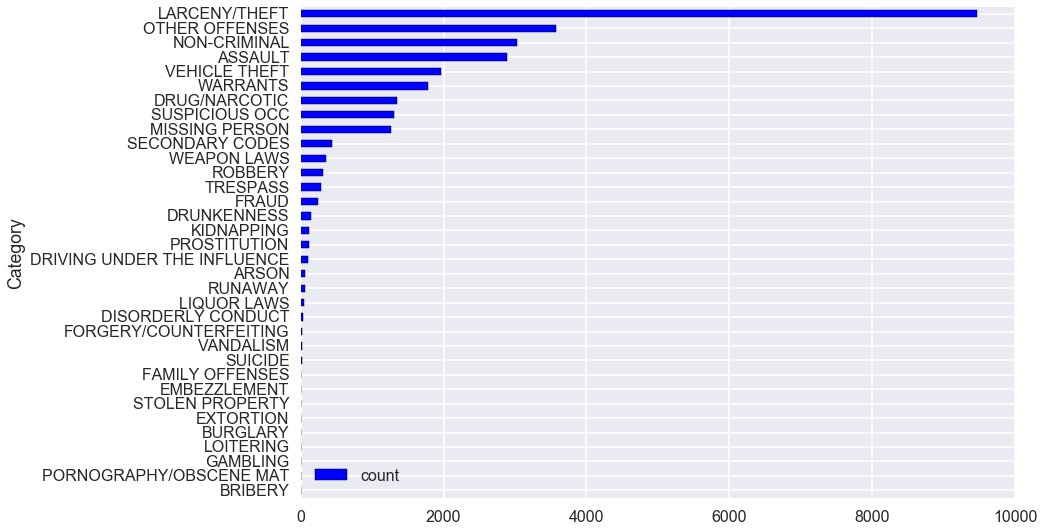

In [24]:

#count_by_ctg = sanfran.groupby(['Category']).size()
#count_by_ctg.sort_values(ascending=True,inplace=True)
#ax = count_by_ctg.plot(kind="barh",sort_columns=True)
count_by_category = pd.DataFrame({'count' : incidents.groupby( ['Category'] ).size()}).reset_index()
count_by_category.sort_values(by='count',ascending= True,inplace=True)
count_by_category['category_idx'] = list(range(len(count_by_category.index)))
ax = count_by_category.plot(kind="barh",x='Category', y='count',sort_columns=True)
#df.groupby(key_columns).size()

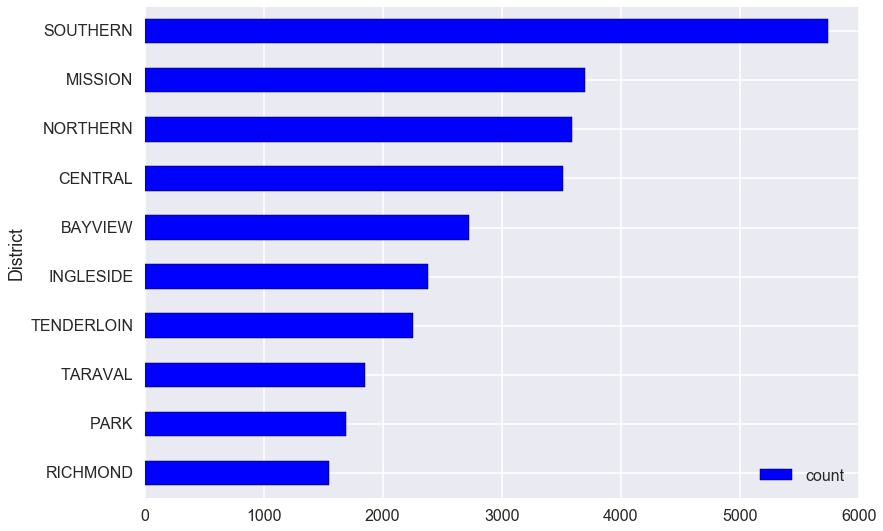

In [25]:
#drunken = sanfran[sanfran['Category'] == 'DRUNKENNESS']
#count_by_district = sanfran.groupby(['PdDistrict']).size()
#count_by_district.sort_values(ascending=True,inplace=True)
count_by_district = pd.DataFrame({'count' : incidents.groupby( ['District'] ).size()}).reset_index()
count_by_district.sort_values(by='count',ascending= True,inplace=True)
count_by_district['district_idx'] = list(range(len(count_by_district.index)))
ax = count_by_district.plot(kind="barh",x='District', y='count',sort_columns=True)

In [26]:
#count_by_district = pd.DataFrame({'count' : incidents.groupby( ['District','Hour'] ).size()}).reset_index()
#count_by_district.sort_values(by='count',ascending= True,inplace=True)
#count_by_district['district_idx'] = list(range(len(count_by_district.index)))
#count_by_district
#ax = count_by_district.plot() #kind="barh",x='District', y='count',sort_columns=True)

In [37]:
categories = dict(zip(count_by_category.Category,count_by_category.category_idx))
districts = dict(zip(count_by_district['District'], count_by_district['district_idx']))
districts

{'BAYVIEW': 5,
 'CENTRAL': 6,
 'INGLESIDE': 4,
 'MISSION': 8,
 'NORTHERN': 7,
 'PARK': 1,
 'RICHMOND': 0,
 'SOUTHERN': 9,
 'TARAVAL': 2,
 'TENDERLOIN': 3}

(0, 9)

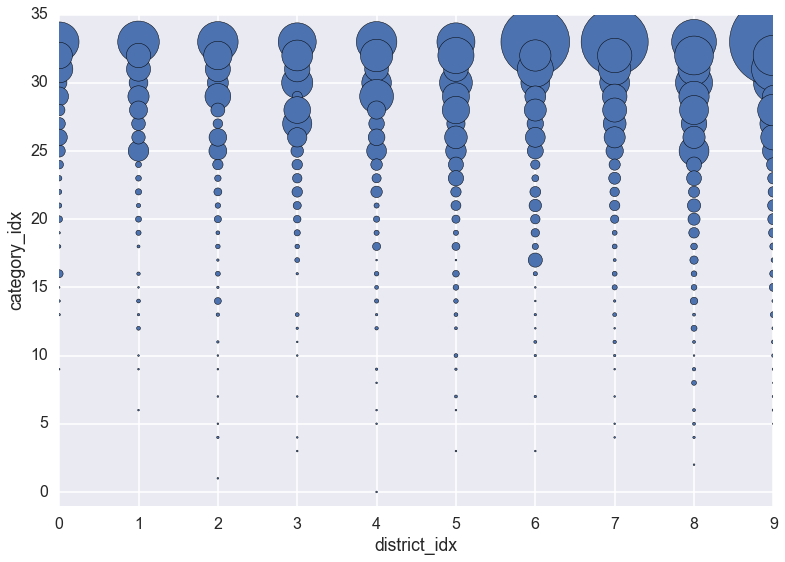

In [42]:
ctg_x_district = pd.DataFrame({'count' : incidents.groupby( ['District', 'Category'] ).size()}).reset_index()
ctg_x_district.columns
ctg_x_district['district_idx'] = ctg_x_district['District'].apply(lambda col: districts[col])
ctg_x_district['category_idx'] = ctg_x_district['Category'].apply(lambda col: categories[col])
ctg_x_district
ax = ctg_x_district.plot(kind='scatter',x=3,y=4,s=ctg_x_district['count']*3)
ax.set_ylim(-1,35)
ax.set_xlim(0,9)
#ax.set_xticklabels(count_by_district['PdDistrict'])
#by_date = sanfran.pivot_table('IncidntNum', aggfunc='count',
#                            index='Category',
#                            columns='PdDistrict' )
#ctg_x_district.plot(kind='scatter',x=1,y=2)
#g = sns.FacetGrid(ctg_x_district, row="Category", col="incident_hour")
#g.map(plt.hist, "count")

In [16]:
count_by_category

,Category,count,category_idx
2,BRIBERY,1,0
21,PORNOGRAPHY/OBSCENE MAT,1,1
13,GAMBLING,1,2
17,LOITERING,3,3
3,BURGLARY,6,4
9,EXTORTION,7,5
26,STOLEN PROPERTY,8,6
8,EMBEZZLEMENT,10,7
10,FAMILY OFFENSES,10,8
27,SUICIDE,14,9


In [ ]:
plt.style.available

In [ ]:
district

In [17]:
ctg_x_dist_x_weekday = pd.DataFrame({'count' : incidents.groupby( ['District', 'Category','Hour'] ).size()}).reset_index()

ValueError: left cannot be >= right

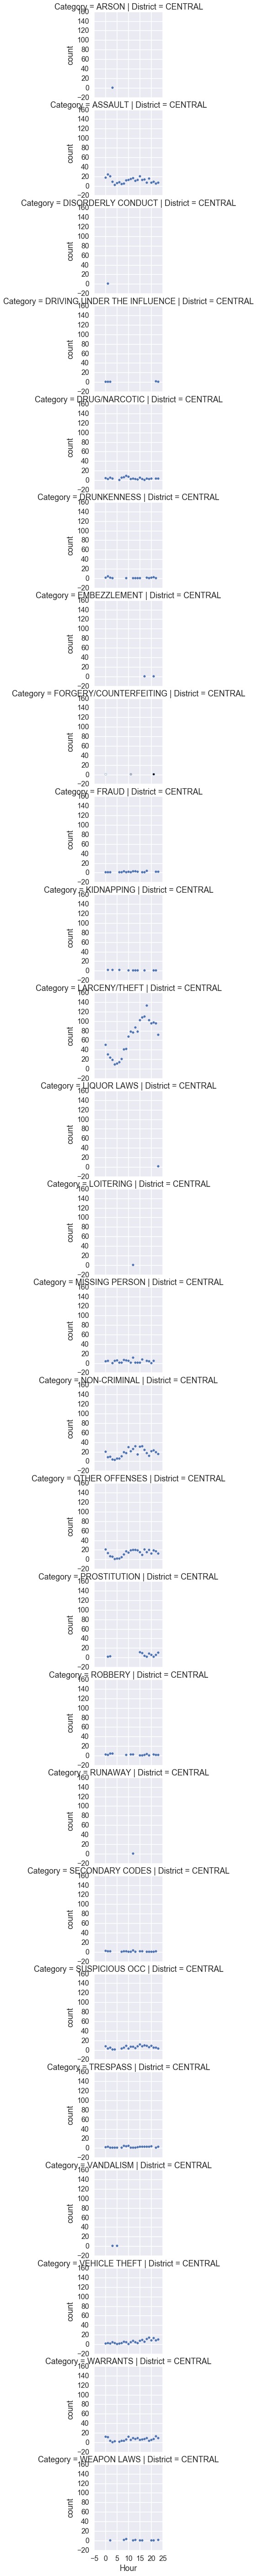

In [18]:
#ctg_x_district.columns
district = ctg_x_dist_x_weekday[ctg_x_dist_x_weekday['District'] == 'CENTRAL']
g = sns.FacetGrid(district, row="Category", col="District")
g.map(plt.scatter, "Hour", "count")

TypeError: 'NoneType' object is not iterable

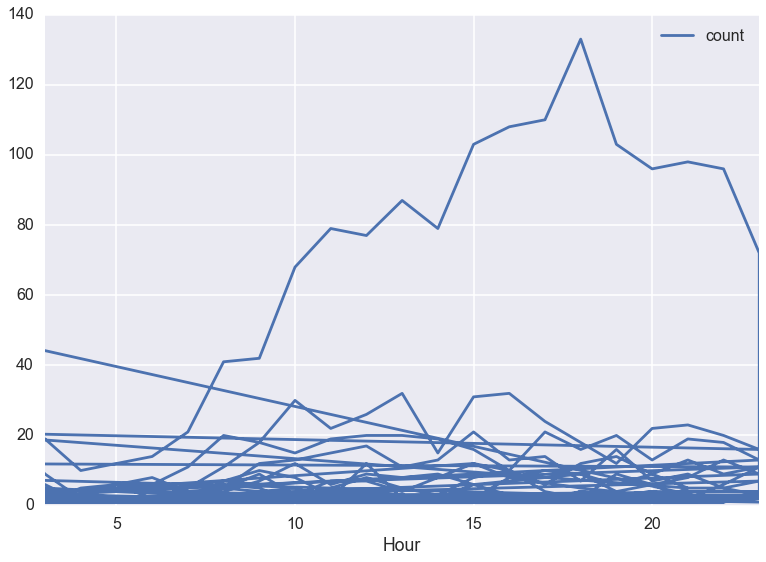

In [43]:
filtered = incidents[incidents['District'] == 'CENTRAL']
#filtered = prostitution[prostitution['District'] == 'CENTRAL]
by_district_hour = pd.DataFrame({'count' : filtered.groupby( ['Category','Hour'] ).size()}).reset_index()
#by_district_hour.sort_values(by='count',ascending= True,inplace=True)
#by_district_hour
by_district_hour.plot(x='Hour',y='count')

In [ ]:
ctg_city = incidents.groupby(['District','Category']).size()

incidents.plot(kind='scatter', x='District', y='Category');

In [ ]:
by_date = incidents.pivot_table('Id', aggfunc='count',
                            index='Date',
                            columns='Category' )
ax = by_date.plot()
ax.figure.savefig('figs/sfo_incidents_by_date.png', bbox_inches='tight')

### San Francisco Incidents trend by weekday (By Category)

In [ ]:
by_weekday = incidents.pivot_table('Id', aggfunc='count',
                            index='Weekday',
                            columns='Wategory' )
ax = by_weekday.plot()
ax.figure.savefig('figs/sfo_incidents_by_weekday.png', bbox_inches='tight')

### San Francisco Incidents trend by hour (By Category)

In [ ]:
by_hour = incidents.pivot_table('Id', aggfunc='count',
                            index='Hour',
                            columns='Category' )
ax = by_hour.plot()
ax.figure.savefig('figs/sfo_incidents_by_hour.png', bbox_inches='tight')

In [ ]:
property_theft = sanfran[sanfran['incident_category'] == 'PROPERTY']
inchoate = sanfran[sanfran['incident_category'] == 'INCHOATE']
personal = sanfran[sanfran['incident_category'] == 'PERSONAL']
non_criminal = sanfran[sanfran['incident_category'] == 'NON-CRIMINAL']
statutory = sanfran[sanfran['incident_category'] == 'STATUTORY']

In [ ]:
by_date = incidents.pivot_table('Id', aggfunc='count',
                            index='Date',
                            columns='Category' )
ax = by_date.plot()
ax.figure.savefig('figs/sfo_by_date_and_category.png', bbox_inches='tight')

In [ ]:
by_weekday = incidents.pivot_table('Id', aggfunc='count',
                            index='Weekday',
                            columns='Category' )
ax = by_weekday.plot()
ax.figure.savefig('figs/sfo_by_weekday_and_category.png', bbox_inches='tight')

In [ ]:
by_hour = incidents.pivot_table('Id', aggfunc='count',
                            index='Hour',
                            columns='Category' )
ax = by_hour.plot()
ax.figure.savefig('figs/sfo_incidents_by_hour.png', bbox_inches='tight')

In [ ]:
state_topo = r'maps/us_states.topo.json'
county_topo = r'maps/us_counties.topo.json'
geo_data = [{'name': 'counties',
             'url': county_topo,
             'feature': 'us_counties.geo'}
            ,{'name': 'states',
             'url': state_topo,
             'feature': 'us_states.geo'}]

vis = Map( geo_data=geo_data
         , scale=4000
         , translate=[1480, 830]
         , projection='albersUsa'
         , map_key={'wa_counties': 'properties.COUNTY'})
del vis.marks[1].properties.update
vis.marks[0].properties.update.fill.value = '#084081'
vis.marks[1].properties.enter.stroke.value = '#fff'
vis.marks[0].properties.enter.stroke.value = '#7bccc4'
vis.display()

### Analysis for San Francisco

* Most incidents are related to property
* All others fall into a general second position
* Inchoate incidents seem to be the least in San Francisco
* The hourly trend is different for San Francisco. There is an increase in incidents post 5 am and reaches a peak aroung 18:00 hours after which the rate declines until it reaches a low at 5 am. This is most evident in the property related incidents, however the trend seems to apply to the other categories.

## Conclusion

Property/Theft related incidents are highest across both states. Incident peaks at different times of the day and are highe 